In [1]:
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextGenerationPipeline, AdamW
import torch
import torch.nn as nn
import transformers

In [2]:

class JointSeqClassifier(transformers.DistilBertForSequenceClassification):
    '''
    A class that inherits from DistilBertForSequenceClassification, but extends the model to 
    have multiple classifiers at the end to perform joint classification over multple tasks.
    '''
    def __init__(self, config, num_tasks=1):
        super().__init__(config)
        self.num_labels = config.num_labels
        self. num_tasks = num_tasks

        self.distilbert = transformers.DistilBertModel(config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        # List of classifiers
        self.classifier = nn.ModuleList([nn.Linear(config.dim, config.num_labels) \
                           for i in range(num_tasks)])
        self.dropout = nn.Dropout(config.seq_classif_dropout)

        self.init_weights()
        
    def forward(
        self,
        input_ids,
        task_ids, 
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        
        task_ids (list of ints):
            Labels indexing which classification task the labels correspond to.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        
        
        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
                
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        
        logits_list = []
        loss = 0
        for i in task_ids:
            logits = self.classifier[i](pooled_output)  # (bs, num_labels)
            logits_list.append(logits)
            if labels != None:
                if self.num_labels == 1:
                    loss_fct = nn.MSELoss()
                    loss += loss_fct(logits.view(-1), labels.view(-1))
                else:
                    loss_fct = nn.CrossEntropyLoss()
                    loss += loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits_list,) + distilbert_output[1:]
            return ((loss,) + output) if loss is not None else output
        
        if output_hidden_states:
            for h_state in distilbert_output.hidden_states:
                h_state.retain_grad()
                
        return transformers.modeling_outputs.SequenceClassifierOutput(
            loss=loss,
            logits=logits_list,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        )

In [3]:
# TESTING JOINT MODEL
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", 
                                          model_max_length=64)

model = JointSeqClassifier.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english",
                                            num_tasks=2)

# Try only updating final layers
params_to_update = [[] for i in range(model.num_tasks)]

for i in range(model.num_tasks):
    for name, param in model.named_parameters():
        if f"classifier.{i}." in name:
            params_to_update[i].append(param)

optims = [AdamW(params_to_update[i], lr=5e-5) for i in range(model.num_tasks)]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing JointSeqClassifier: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing JointSeqClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing JointSeqClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of JointSeqClassifier were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['classifier.0.weight', 'classifier.0.bias', 'classifier.1.weight', 'classifier.1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

JointSeqClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Line

In [4]:

# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", model_max_length=64)
# model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# # Try only updating final layers
# params_to_update = []

# for name,param in model.named_parameters():
#     if 'classifier' in name:
#         params_to_update.append(param)
        
# optim = AdamW(params_to_update, lr=5e-5)

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model.to(device)

In [5]:
def train_single(input_tensor_batch, target_tensor_batch, 
                 model, model_optimizer, task_ids):
    '''
    A single forward and backward pass of the neural net on a single training batch.
    
    Arguments:
    
        - input_tensor_batch  : list of tensors. 
                                A batch of encoded sentence inputs and is
                                of size (batch_size, max_length).
        - target_tensors_batch : list of tensors
                                 Each tensor represents a batch of class labels.
                                 Each tensor is of size (batch_size, 1).
        - model                : PyTorch sequence classifier model.  
                                 Assumed to be a JointSeqClassifier or 
                                 DistilBertForSequenceClassification model
        - model_optimizer      : PyTorch Optimizer.
                                 The optimizer used by the model for training.
        - task_ids             : list of ints.
                                 List of the indices for the tasks on which we're training. 
                                 Although it is a list, currently it only works if the list 
                                 is a single element (for the JointSeqClassifier model). TODO:
                                 fix this. 
                           
    Returns:
    
        - loss : float.
                 The loss of this training run.
        
    '''
    model_optimizer.zero_grad()
    output = model(input_ids=input_tensor_batch.to(device),  
                   task_ids=task_ids, 
                   labels = target_tensor_batch.to(device),
                   output_attentions=False)
    loss = output[0]
    loss.backward()
    model_optimizer.step()
    return loss.item()

def train(input_tensors, target_tensors, input_val_tensors, target_val_tensors,
          model, model_optimizer, n_epochs, task_ids):
    '''
    Train the classfier for a given number of epochs on the whole training set.
    
    Arguments:
    
        - input_tensors   : list of tensors. 
                            Each entry in the list is a single batch of encoded 
                            sentence inputs and is of size (batch_size, max_length).
        - target_tensors  : list of tensors
                            Each tensor represents a batch of class labels.
                            Each tensor is of size (batch_size, 1).
        - model           : PyTorch sequence classifier model.  
                            Assumed to be a JointSeqClassifier or 
                            DistilBertForSequenceClassification model
        - model_optimizer : PyTorch Optimizer.
                            The optimizer used by the model for training.
        - n_epochs        : int.
                            The number of epochs to train for. 
                            Each epoch is an entire pass over the data. 
        - task_ids        : list of ints.
                            List of the indices for the tasks on which we're training. 
                            Although it is a list, currently it only works if the list 
                            is a single element (for the JointSeqClassifier model). TODO:
                            fix this. 
                           
    Returns:
    
        - loss : float.
                 The loss of this training run.
    '''
    model.train()
    losses = []
    train_accs = []
    val_accs = []
    # Iterate over given num of epochs
    for epoch in range(n_epochs):
        loss = 0
        # Iterate over batches
        for i in tqdm.tqdm(range(len(input_tensors)), desc="training batches progress"):
            input_tensor = input_tensors[i]
            target_tensor = target_tensors[i]
            loss += train_single(input_tensor, target_tensor, model, 
                                 model_optimizer, task_ids)
        print(f"Epoch {epoch} :") 
        print(f"\tLoss {loss/len(input_tensors):.4f}")
        train_accuracy = get_accuracy(input_tensors, target_tensors, model)
        val_accuracy = get_accuracy(input_val_tensors, target_val_tensors, model)
        print(f"\tTraining Accuracy {train_accuracy:.4f}")
        print(f"\tValidation Accuracy {val_accuracy:.4f}")
        losses.append(loss/len(input_tensors))
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    return losses, train_accs, val_accs

def get_accuracy(input_tensors, target_tensors, model, task_num=0):
    '''
    Get model accuracy for the corresponding task. 
    
    Arguments:
    
        - input_tensors  : list of tensors. 
                           Each tensor represents a batch of encoded sentence inputs and is
                           of size (batch_size, max_length).
        - target_tensors : list of tensors
                           Each tensor represents a batch of class labels.
                           Each tensor is of size (batch_size, 1).
        - model          : PyTorch sequence classifier model.  
                           Assumed to be a JointSeqClassifier or 
                           DistilBertForSequenceClassification model
        - task_num       : int.
                           represents the index of the specific task we are evaluating.
                           
    Returns:
    
        - accuracy : float.
                     Classification accuracy of the model on this data and task.
    '''
    with torch.no_grad():
        model.eval()
        accs = []
        # Iterate over batches
        for i in tqdm.tqdm(range(len(input_tensors)), desc="accuracy batches progress"):
            input_tensor_batch = input_tensors[i].to(device)
            target_tensor_batch = target_tensors[i].to(device)
            # Run the model
            output = model(input_tensor_batch, 
                           output_attentions=False, 
                           task_ids=[task_num])
            # Get classification prediction for the task of interest
            preds = output.logits[task_num].argmax(axis=1)
            # Get accuracy of given batch
            batch_acc = ((preds == target_tensor_batch).sum() \
                         / target_tensor_batch.shape[0]).item()
            # Add accuracy to list of accuracies
            accs.append(batch_acc)
        # Return the total accuracy, averaged over the batches
        return np.mean(accs)

def sent_pred(sent, model, tokenizer, device, batch_size):
    '''
    Runs the model on an input sentence.
    
    Arguments: 
    
      sent  : str. 
              The input sentence.
      model : the PyTorch sequence classifier model.  
              Assumed to be a JointSeqClassifier or 
              DistilBertForSequenceClassification model
    Returns:
    
      pred  : np array. 
              The prediction, wich is a normalized array with a value for \
              each class, representing the predicted probability for that class
      attns : tuple of tensors
              each entry in tuple is the attention matrix for an attention head.
    '''
    model.eval()
    input_tensor = tokenizer.encode(sent, return_tensors="pt").to(device)

    output = model(input_tensor, output_attentions=True, task_ids=range(len(model.classifier)))

    preds = []
    scores = []
    # Iterate over tasks and get class predition and scorews for each.
    for i in range(model.num_tasks):
        pred = output.logits[i].argmax(axis=1)

        softmax = torch.nn.Softmax(dim=1)
        score = softmax(output.logits[i].detach())

        preds.append(pred.detach().cpu().numpy())
        scores.append(score)

    attns = output.attentions

    return preds, scores, attns

In [6]:
# Stanford Politeness:
train_polite_file = "../../../cross_style_transfer_internal/data/xslue/StanfordPoliteness/train.tsv"
dev_polite_file = "../../../cross_style_transfer_internal/data/xslue/StanfordPoliteness/dev.tsv"
train_polite_data = pd.read_csv(train_polite_file, names=['domain', 'id', 'text', 'score'], sep='\t')
val_polite_data = pd.read_csv(dev_polite_file, names=['domain', 'id', 'text', 'score'], sep='\t')


# Short Humor
train_humor_file = "../../../cross_style_transfer_internal/data/xslue/ShortHumor/train.tsv"
dev_humor_file = "../../../cross_style_transfer_internal/data/xslue/ShortHumor/dev.tsv"
train_humor_data = pd.read_csv(train_humor_file, names=['domain', 'score', 'text'], sep='\t', error_bad_lines=False)
val_humor_data = pd.read_csv(dev_humor_file, names=['domain', 'score', 'text'], sep='\t', 
                       quoting=3, error_bad_lines=False)

# Dictionary for the classes for each task
task_names = ["Politeness", "Humor"]
class_labels_dict = [{0: "impolite", 1 : "polite"}, 
                     {0: "humorous", 1 : "not humorous"}]

In [7]:
def parse_humor(humor_df):
    '''
    Parse short humor dataframe into the format we need for classification.
    
    Returns a DataFrame with two columns, one for the input text and one for the class labels.
    '''
    input_df = pd.DataFrame()
    input_df['text'] = humor_df['text']
    input_df['label'] = humor_df['score']
    return input_df

def parse_stanford_politeness(polite_df):
    '''
    Parse stanford politeness dataframe into the format we need for classification.
    
    Returns a DataFrame with two columns, one for the input text and one for the class labels.
    '''
    input_df = pd.DataFrame()
    input_df['text'] = polite_df['text']
    # Map scores >= 0 (polite) to label 1 and scores < 0 (impolite) to label 0.
    input_df['label'] = polite_df['score'].apply(lambda x : int(x >= 0))
    return input_df

def df_to_training_pairs(df, tokenizer, batch_size):
    '''
    Convert DataFrames with a 'text' and 'label' column into two lists of tensors, 
    one with texts encoded by the tokenizer and one with the class labels.
    '''
    input_tensors = df['text'].apply(lambda x : tokenizer.encode(x, 
                                                                 padding='max_length', 
                                                                 truncation=True, 
                                                                 return_tensors="pt"))
    target_tensors = df['label'].apply(lambda x : torch.LongTensor([x]))
    return input_tensors.values.reshape(-1, batch_size).tolist(), target_tensors.values.reshape(-1, batch_size).tolist()

In [8]:
# Get DataFrames for tasks
train_polite_df = parse_stanford_politeness(train_polite_data)
val_polite_df = parse_stanford_politeness(val_polite_data)

train_humor_df = parse_humor(train_humor_data)
val_humor_df = parse_humor(val_humor_data)

In [9]:
batch_size = 32
input_polite_tensors, target_polite_tensors = df_to_training_pairs(train_polite_df.head((len(train_polite_df)//batch_size)*batch_size), 
                                                                   tokenizer, batch_size)
input_polite_val_tensors, target_polite_val_tensors = df_to_training_pairs(val_polite_df.head((len(val_polite_df)//batch_size)*batch_size), 
                                                                  tokenizer, batch_size)

input_humor_tensors, target_humor_tensors = df_to_training_pairs(train_humor_df.head((len(train_humor_df)//batch_size)*batch_size), 
                                                                   tokenizer, batch_size)
input_humor_val_tensors, target_humor_val_tensors = df_to_training_pairs(val_humor_df.head((len(val_humor_df)//batch_size)*batch_size), 
                                                                  tokenizer, batch_size)

In [10]:
for i in range(len(target_polite_tensors)):
    input_polite_tensors[i] = torch.stack(input_polite_tensors[i])
    input_polite_tensors[i] = input_polite_tensors[i].reshape(len(input_polite_tensors[i]), 
                                       input_polite_tensors[i].shape[2])
    target_polite_tensors[i] = torch.LongTensor(target_polite_tensors[i])
for i in range(len(target_polite_val_tensors)):
    input_polite_val_tensors[i] = torch.stack(input_polite_val_tensors[i])
    input_polite_val_tensors[i] = input_polite_val_tensors[i].reshape(len(input_polite_val_tensors[i]), 
                                       input_polite_val_tensors[i].shape[2])
    target_polite_val_tensors[i] = torch.LongTensor(target_polite_val_tensors[i])

In [11]:
for i in range(len(target_humor_tensors)):
    input_humor_tensors[i] = torch.stack(input_humor_tensors[i])
    input_humor_tensors[i] = input_humor_tensors[i].reshape(len(input_humor_tensors[i]), 
                                       input_humor_tensors[i].shape[2])
    target_humor_tensors[i] = torch.LongTensor(target_humor_tensors[i])
for i in range(len(target_humor_val_tensors)):
    input_humor_val_tensors[i] = torch.stack(input_humor_val_tensors[i])
    input_humor_val_tensors[i] = input_humor_val_tensors[i].reshape(len(input_humor_val_tensors[i]), 
                                       input_humor_val_tensors[i].shape[2])
    target_humor_val_tensors[i] = torch.LongTensor(target_humor_val_tensors[i])

In [12]:
# train_single(input_tensors[0], target_tensor_joint_test, model, optim)

In [15]:
train_epochs = 1
train(input_polite_tensors, target_polite_tensors, 
      input_polite_val_tensors, target_polite_val_tensors, 
      model, optims[0], train_epochs, task_ids=[0])

train(input_humor_tensors, target_humor_tensors, 
      input_humor_val_tensors, target_humor_val_tensors, 
      model, optims[1], train_epochs, task_ids=[1])

accuracy batches progress:   1%|          | 2/308 [00:00<00:20, 14.99it/s]

Epoch 0 :
	Loss 0.6841


training batches progress:   0%|          | 0/1181 [00:00<?, ?it/s]

	Training Accuracy 0.5496
	Validation Accuracy 0.5605


accuracy batches progress:   0%|          | 2/1181 [00:00<01:21, 14.51it/s]

Epoch 0 :
	Loss 0.6467


accuracy batches progress: 100%|██████████| 65/65 [00:04<00:00, 14.30it/s]

	Training Accuracy 0.5002
	Validation Accuracy 0.4990


([0.6466668239596736], [0.5001587637595258], [0.49903846153846154])

In [16]:
sent = "Could you please help me?"

preds, scores, attns = sent_pred(sent, model, tokenizer, device, batch_size)

In [17]:
# Sum over attention vectors for each head and handle dimensions and move to cpu
viz_attns = np.array([attn.sum(axis=1).cpu().detach().squeeze().numpy() for attn in attns])
# Sum over heads
viz_attns = viz_attns.sum(axis=0)
# Drop cls and sep tokens
viz_attns = viz_attns[0, 1:-1]

In [18]:
tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(sent))[1:-1]
scores = [score.cpu().detach().squeeze().numpy() for score in scores]

Tokenized Input: ['could', 'you', 'please', 'help', 'me', '?']

Task: Politeness
Style: polite
Class Scores: polite : 63.15%, impolite : 36.85%

Task: Humor
Style: not humorous
Class Scores: not humorous : 72.54%, humorous : 27.46%



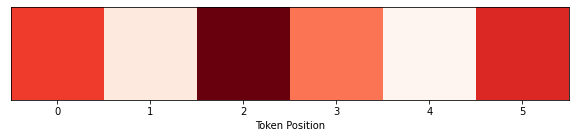

In [19]:
# Create heatmap
print(f"Tokenized Input: {tokens}\n")
for i, task_name in enumerate(task_names):
    print(f"Task: {task_name}")
    print(f"Style: {class_labels_dict[i][preds[i][0]]}")
    print(f"Class Scores: {class_labels_dict[i][1]} : {scores[i][1]*100:.2f}%, {class_labels_dict[i][0]} : {scores[i][0]*100:.2f}%\n")
fig, ax = plt.subplots(figsize=(10, 2))
ax.get_yaxis().set_visible(False)
ax.set_xlabel("Token Position")
plt.imshow([viz_attns], cmap='Reds');
#plt.savefig(f'Attention_humor_and_politeness_heatmap_{"_".join(sent.split())}.png')

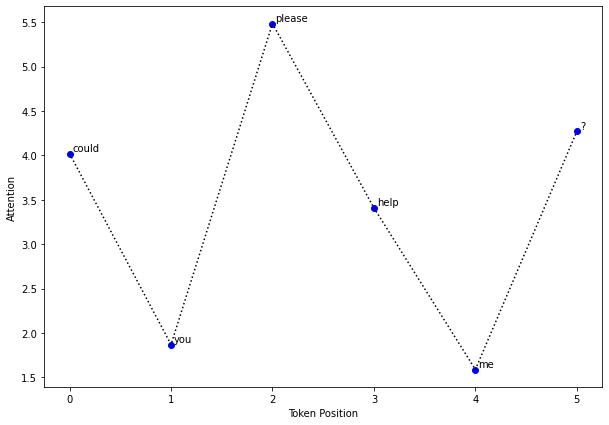

In [20]:
y = viz_attns
x = np.arange(len(tokens))
labels = tokens

fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(x, y, 'bo')
plt.plot(x, y, 'k:')
ax.set_ylabel("Attention")
ax.set_xlabel("Token Position")

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]), xytext=(x[i] + 0.03, y[i] + 0.03))
#plt.savefig(f'Attention_humor_and_politeness_plot_{"_".join(sent.split())}.png')

In [ ]:
# save_model = False
# checkpoint_path = "../models/BERT_Joint_EarlyTest"
# if save_model:
#     model.save_pretrained(checkpoint_path)

In [34]:
def salience(sent, model, tokenizer, device, 
             batch_size, task_num, label_num):
    '''
    Runs the model on an input sentence and gives the salience for each token that 
    is a representation of how much a given token is contributing to the score of a 
    given class for a given classification task.
    
    Arguments: 
    
      sent       : str. 
                   The input sentence.
      model      : the PyTorch sequence classifier model.  
                   Assumed to be a JointSeqClassifier or 
                   DistilBertForSequenceClassification model
      tokenizer  : Transformers tokenizer.
                   The tokenizer used to encode the input string. 
                   Assumed to be compatible with model.
      device     : torch.device. 
                   The device to be used (cuda or cpu)
      batch_size : int. 
                   The batch_size used by the model.
      task_num   : int. 
                   Index for the classification task we are interested in.
      label_num  : int.
                   Index for the class label for the task corresponding to task_num.
                   For example if task 0 is a politeness classificaition 
                   task and class 1 is "polite", then setting task_num = 0 and 
                   label_num = 1 would give us a representation of how much each 
                   token is contributing to labelling the sentence as "polite".
    Returns:
    
      saliency : Tensor of floats with length equal to length of tokenized sent.
                 The gradient of the particular output we are interested in (the score for 
                 class 'label_num' for task 'task_num') wrt the input tokens.
    '''
    # Set model to evaluation mode
    model.eval()
    # Tokenize input
    input_tensor = tokenizer.encode(sent, return_tensors="pt").to(device)
    # Run the model and get the output
    output = model(input_tensor, output_attentions=True, output_hidden_states=True, 
                   task_ids=range(len(model.classifier)))
    # Get the score for the desired task,class combination
    class_score = output.logits[task_num][0][label_num]
    # backprop
    class_score.backward()
    # get the gradients
    grads = [h_state.grad for h_state in output[2]]
    # Take the max over the heads and the embedding dim. 
    # TODO, consider a better way (perhaps use sum instead or max,sum combo)
    saliency = torch.stack(grads).abs().max(axis=0)[0].squeeze().max(axis=1)[0]
    return saliency

In [35]:
sent = "Could you please help me?"

In [36]:
input_tensor = tokenizer.encode(sent, return_tensors="pt").to(device)

In [37]:
output = model(input_tensor, output_attentions=True, output_hidden_states=True,
               task_ids=range(len(model.classifier)))

In [38]:
salience(sent, model, tokenizer, device, batch_size, 0, 0)

tensor([0.0291, 0.0080, 0.0049, 0.0132, 0.0154, 0.0035, 0.0044, 0.0177],
       device='cuda:0')